> ## "The goal of parameter identification is rarely the parameter estimates. Rather, the ultimate goal is nearly always a prediction problem" 
>-David Freyberg (1988)

In [1]:
%matplotlib inline
import os

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
newparams = {'legend.fontsize':10, 'axes.labelsize':10,
             'xtick.labelsize':10, 'ytick.labelsize':10,
             'font.family':'Univers 57 Condensed', 
             'pdf.fonttype':42}
plt.rcParams.update(newparams)
from IPython.display import Image

# Introduction to the synthetic model for the class

### We have recreated a MODFLOW model that was originally created by David Freyberg at Stanford University in the late 1980s. The  model is a 2-dimensional MODFLOW model with 1 layer,  40 rows, and 20 columns.  The model has 2 stress periods: an initial steady-state stress period used for calibration, and a 10-year transient stress period.  The calibration period uses the recharge and well flux of Freyberg(1988); the forecast stress period uses 25% less recharge and 25% more pumping to represent future drought conditions for a forecast period.

### The inverse problem has 12 head observations, measured at the end of the steady-state calibration period.  The forecasts of interest include the headwater flux during the forecast stress periods (observations named and ``fa_headwaters_0001``), the water level in wells located at row 6 column 4 and row 17 column 18 at the end of the stress periods (observations named ```c001fr05c04``` and ```c001fr16c17```), and `travel_time` from MODPATH.  The forecasts are included in the Jacobian matrix as zero-weight observations. 

### Freyberg, David L. "AN EXERCISE IN GROUND‐WATER MODEL CALIBRATION AND PREDICTION." Groundwater 26.3 (1988): 350-360.

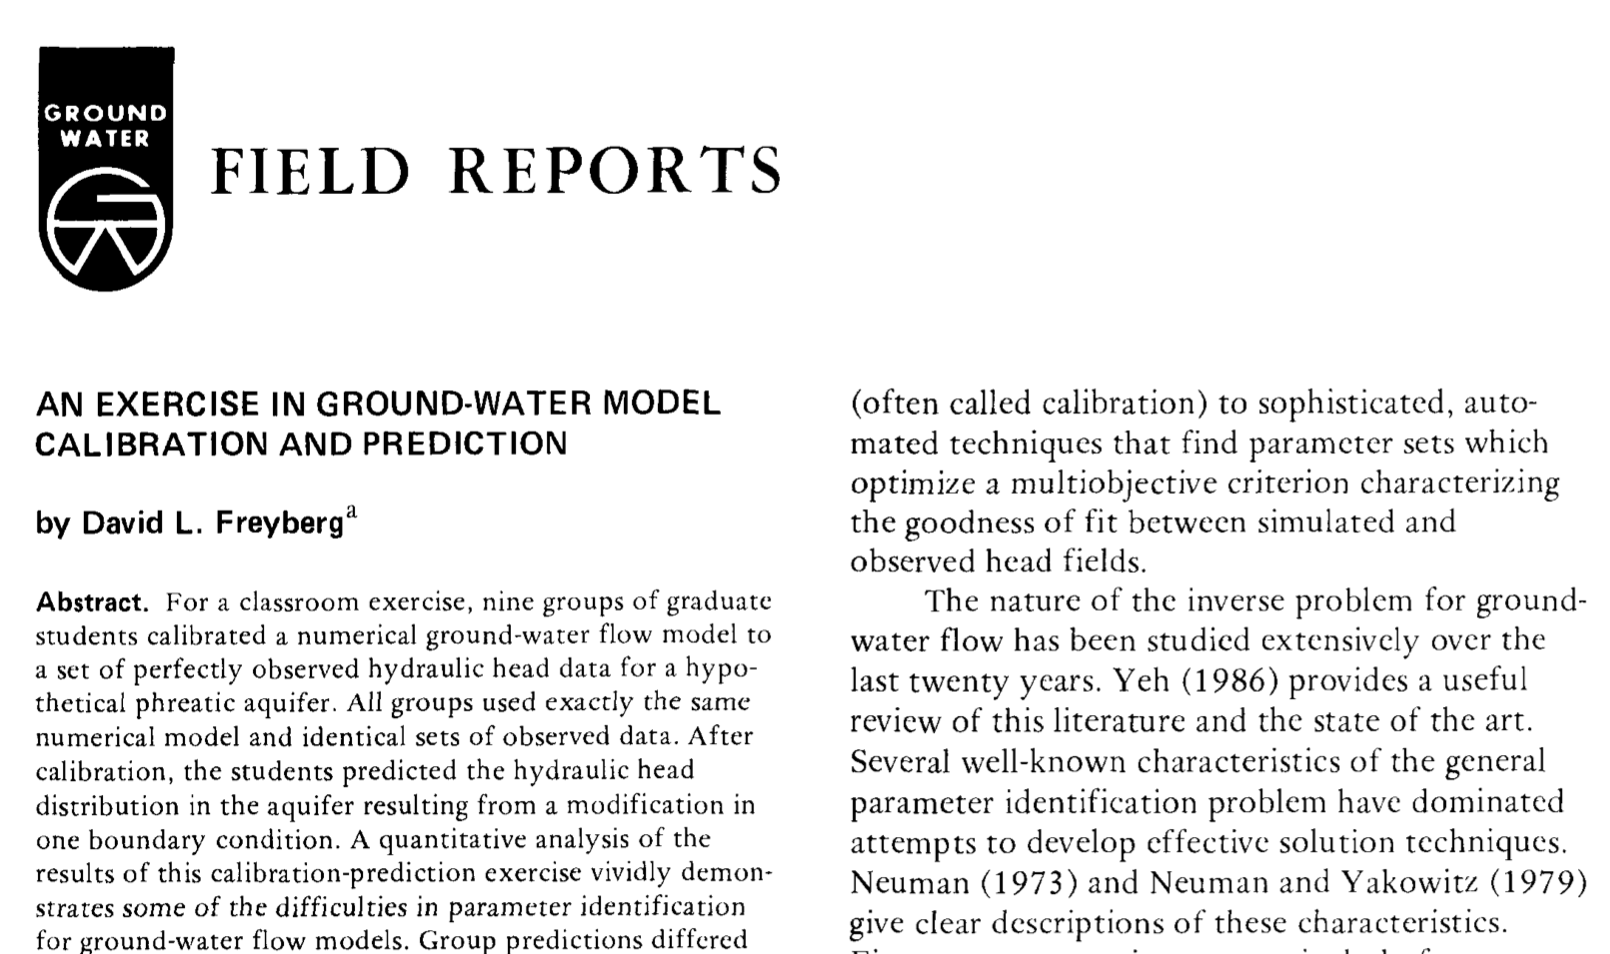

In [2]:
Image(filename='freyberg_paper.png')

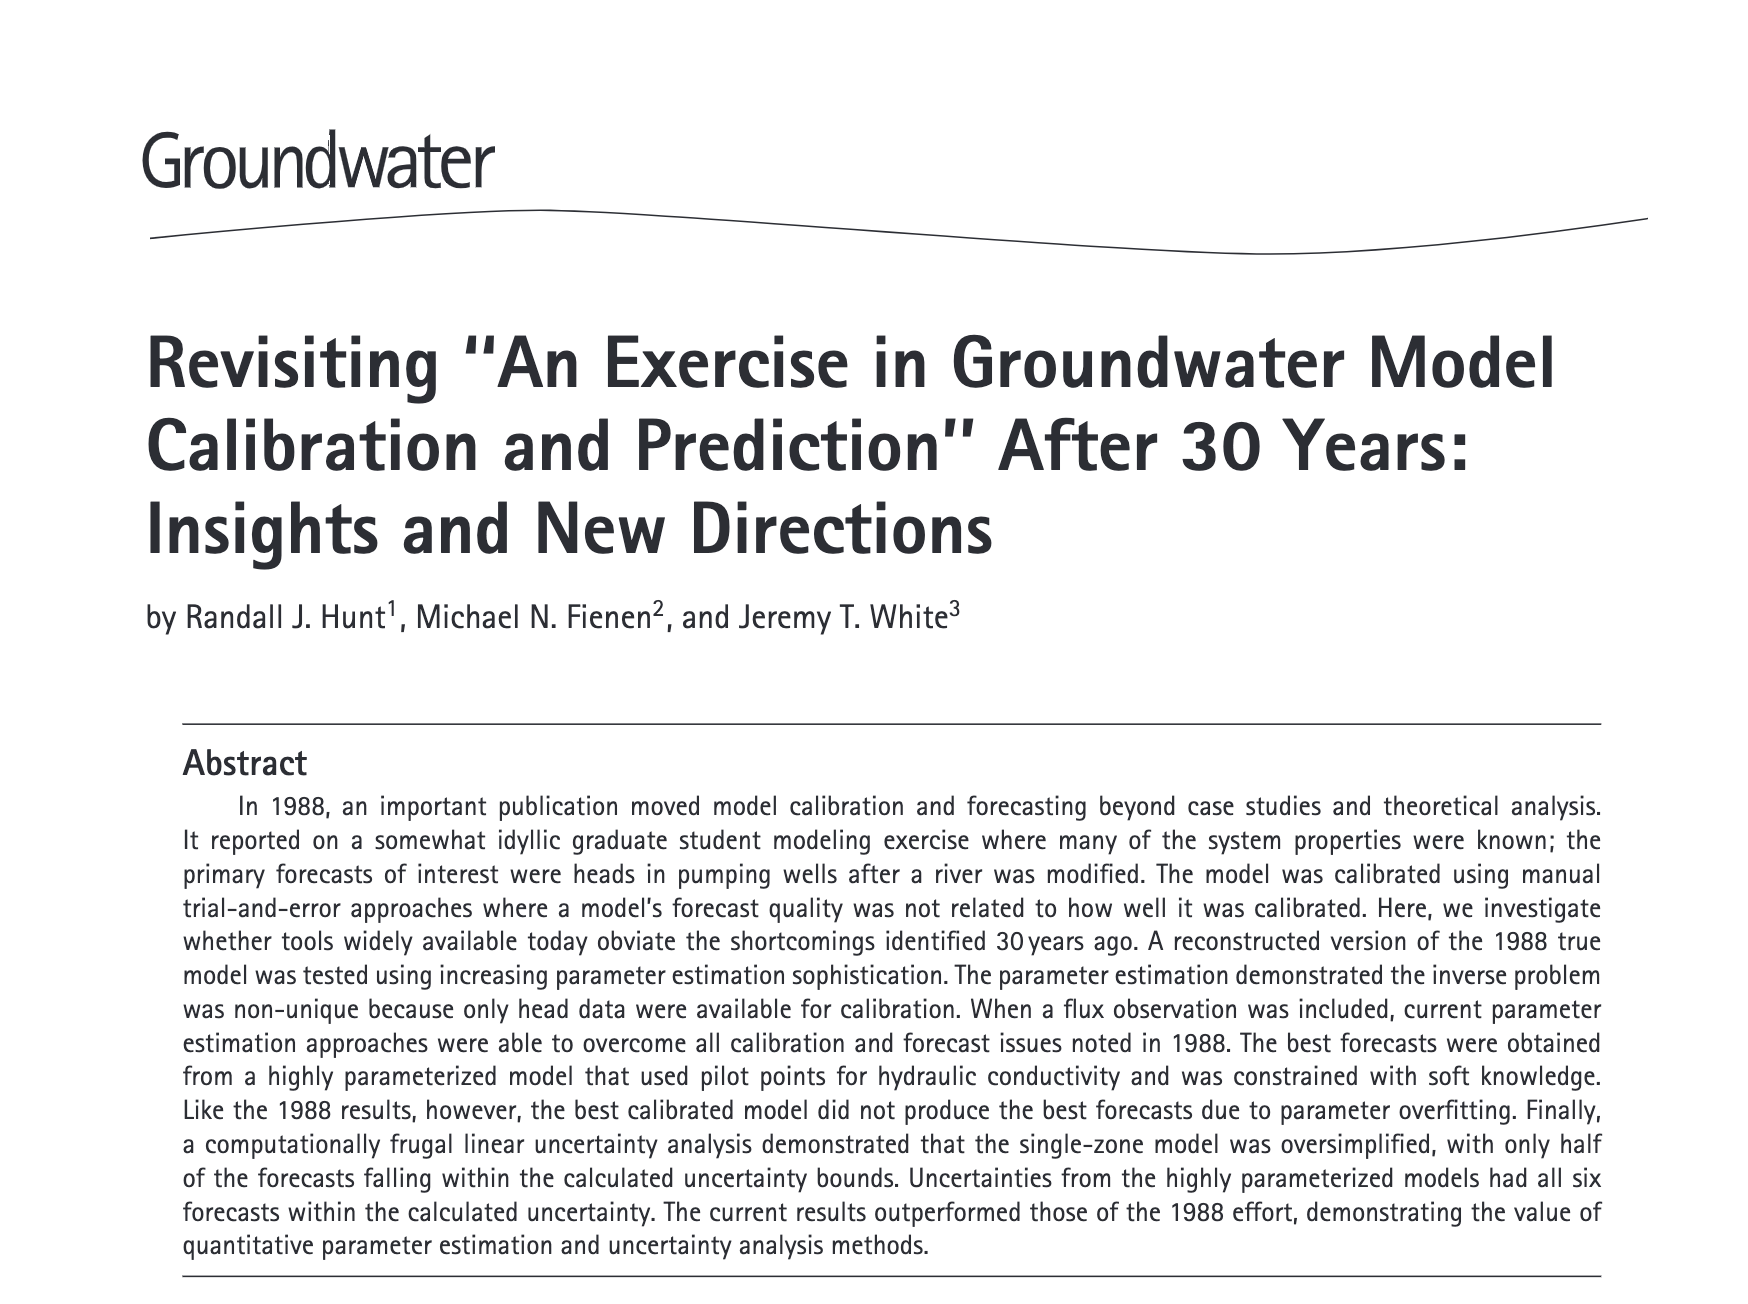

In [3]:
Image(filename='freyberg_revisit_1.png')

# True Properties of the model

In [5]:
hk = [np.loadtxt(os.path.join('..','..',
            'these_arent_the_files_youre_looking_for','hk_Layer_{}.ref'.format(i))) for i in range(1,4)]
ibound = np.loadtxt(os.path.join('..','..','these_arent_the_files_youre_looking_for','ibound_layer_1.ref'))
for i in range(3):
    hk[i][ibound==0] = np.nan
_, ax = plt.subplots(1,3, figsize=(8,8))
for i, k in enumerate(hk):
    cb = ax[i].imshow(hk[i])
    ax[i].set_title('HK lay {}'.format(i+1))

OSError: ..\..\these_arent_the_files_youre_looking_for\hk_Layer_1.ref not found.

# The hydraulic conductivity is a stochastically perturbed realization based on a zoned field from the paper
<img src="true_K.png" style="float: center; width: 25%;  margin-bottom: 0.5em;">


# How about recharge, pumping, and SFR recharge?

# We will see transient recharge in the `flopy` setup notebook

# What did the paper describe and what are we doing?

## David Freyberg designed a simple model to give to a graduate class and asked them to each "calibrate" the model. The data provided to them was pretty extensive: 

### 1. the water level (perfectly represented) in a number of wells
### 2. the bedrock elevation at those same well locations
### 3. all the lateral aquifer geometry
### 4. boundary conditions including lateral flows 
### 5. well pumping rates 

## The forecast of interest was the head if the river channel was lined (e.g. conductance reduced greatly)

## Calibration was judged based on three metrics
## 1. Fit of prediction: $RMSE_P=\sqrt{\frac{1}{6}\sum_{i=1}^{6}\left(\hat{h}_{mod}^{i}-h_{mod}^{i}\right)^{2}}$

## 2. Fit of calibration: $RMSE_K=\sqrt{\frac{1}{705}\sum_{i=1}^{705}\left(\hat{K}_i-K_i\right)^{2}}$

## 3. The number of model runs: $N$

## The students had to make their own metrics of calibration fit using the head observations

# There are interesting insights in the paper, but perhaps the most interesting is this one:

<img src="cal_pred.png" style="float: center; width: 75%;  margin-bottom: 0.5em;">


# So what are we doing with this model?

## The Freyberg paper showed that representing the true properties of a system can lead to good predictions. However, doing a great job of reproducing calibration data _at the expense of reasonable parameters_ hinders rather than helps predictions/forecasts. This is a central theme!

## So we will explore this model, using it to work our way through simple parameterizations and getting more sophisticated as we go. We will explore the ramifications of simplicity and complexity always consider the balance between "calibration" fit and predictive performance.

## We also changed the stream to SFR to be more realistic and let some nonlinearity creep into the model.

## For this kind of class we need a synthetic and kind of simple model so it can run quickly and so we can compare our answers with the truth.

# Calibration Data: 
### We will have the same head values, but they will be corrupted with noise. We will also have river flux as an observation

# Future Condition:
### We want to simulate a future drought condition at the end of our transient time

# Forecasts: 
### Our forecasts include head, headwater river flux, tailwater river flux, and travel time and activity (yes,no) of a particle estimated using MODPATH